In [4]:
import matplotlib.pyplot as plt
import anndata as adata
import scanpy as sc
import pandas as pd
from harmonypy import run_harmony

import snapatac2 as snap
import anndata as ad
import pandas as pd
import scanpy as sc
import scvi
import numpy as np

scvi.settings.seed = 0
snap.__version__
import warnings

warnings.filterwarnings("ignore")


INFO: Seed set to 0
2025-08-23 14:48:55 - INFO - Seed set to 0


In [5]:
import os
default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"

In [6]:
!export OPENBLAS_NUM_THREADS=8
!export MKL_NUM_THREADS=8
!export OMP_NUM_THREADS=8

# Read single cell data

In [60]:
adata_sc = adata.read_h5ad("/data1st1/sch/20250620_anno/128anno.h5ad")
# Fix cell type 22 to neuron
# cluster_22_cells = adata_sc.obs_names[adata_sc.obs['Leiden_clusters_res1.0'] == '22']
# adata_sc.obs.loc[cluster_22_cells, 'celltype.L1'] = 'Neuron'

In [62]:
adata_sc.obs['region'] = adata_sc.obs['region'].cat.rename_categories({'HIP':'HPF'})


In [66]:
adata_sc.obs['region'].unique()

['PFC', 'HPF', 'AMY']
Categories (3, object): ['AMY', 'HPF', 'PFC']

In [32]:
adata_sc.X.max()

8.589245

In [64]:
adata_sc = adata_sc[adata_sc.obs.region.isin(['AMY', 'HPF', 'PFC']) & adata_sc.obs.gender.isin(['M'])]

In [65]:
adata_sc.obs['Neurotransmitter_celltype'].unique()

['NN', 'GABAergic', 'Glutamatergic', NaN]
Categories (3, object): ['GABAergic', 'Glutamatergic', 'NN']

In [ ]:
adata_sc.obs.rename(columns={'batch': 'sample'}, inplace=True)

In [15]:
adata_meth_mcg = sc.read_h5ad("/data1st2/junyi/output/methlypub0823/mcg_geneslop2k-vm23.h5ad")
adata_meth_mch = sc.read_h5ad("/data1st2/junyi/output/methlypub0823/mch_geneslop2k-vm23.h5ad")

In [58]:
adata_sc.obs['region'].unique()

['PFC', 'AMY']
Categories (2, object): ['AMY', 'PFC']

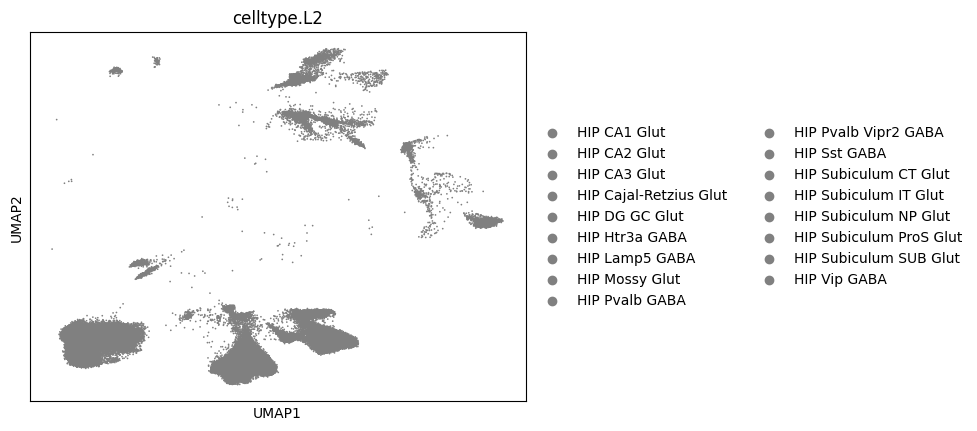

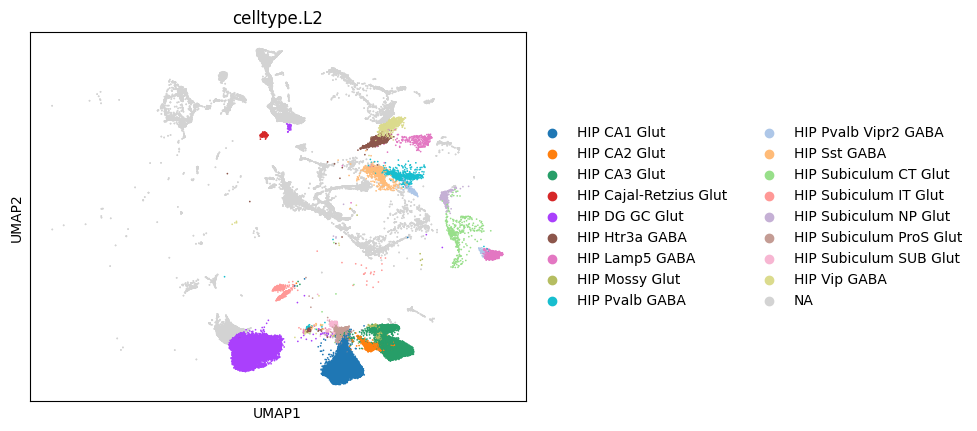

In [ ]:
for region in adata_sc.obs['region'].unique():
#for region in ['HPF']:

    #adata_atac_region_neuron = sc.read_h5ad(f'/data2st1/junyi/output/atac0627/3REGIONS_gene_{region}_Neuron.h5ad')
    adata_cg_region_neuron = adata_meth_mcg[adata_meth_mcg.obs.region.isin([region]) & (adata_meth_mcg.obs.NeuroTransmitters!='NN')]
    adata_ch_region_neuron = adata_meth_mch[adata_meth_mch.obs.region.isin([region]) & (adata_meth_mch.obs.NeuroTransmitters!='NN')]

    adata_sc_region_neuron = adata_sc[adata_sc.obs.region.isin([region]) & adata_sc.obs.Neurotransmitter_celltype.isin(['GABAergic', 'Glutamatergic'])]
    sc.pl.umap(adata_sc_region_neuron, color=['celltype.L2'],size=6, show=True)
    #sc.pp.normalize_per_cell(adata_atac_region_neuron)
    #adata_atac_region_neuron.X.max()
    n_top_genes = 20000
    sc.pp.highly_variable_genes(adata_cg_region_neuron, n_top_genes=n_top_genes, batch_key="Sample")
    sc.pp.highly_variable_genes(adata_ch_region_neuron, n_top_genes=n_top_genes, batch_key="Sample")

    sc.pp.highly_variable_genes(adata_sc_region_neuron, n_top_genes=n_top_genes, batch_key="sample")
    sc_hvf = adata_sc_region_neuron.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_top_genes].index
    cg_hvf = adata_cg_region_neuron.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_top_genes].index
    ch_hvf = adata_ch_region_neuron.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_top_genes].index

    #hvfs = cg_hvf.intersection(ch_hvf).intersection(sc_hvf)
    # query = adata_atac_region_neuron[:,hvfs].copy()
    # reference = adata_sc_region_neuron[:,hvfs].copy()

    sc.pp.scale(adata_ch_region_neuron)
    sc.pp.scale(adata_cg_region_neuron)
    sc.pp.scale(adata_sc_region_neuron)

    adata_ch_region_neuron.X = adata_ch_region_neuron.X * -1
    adata_cg_region_neuron.X = adata_cg_region_neuron.X * -1

    adata_sc_region_neuron.var['gene_name'] = adata_sc_region_neuron.var_names
    adata_sc_region_neuron.var.index = adata_sc_region_neuron.var.gene_ids

    query1 = adata_cg_region_neuron
    query2 = adata_ch_region_neuron
    reference = adata_sc_region_neuron

    query1.obs['celltype.L2'] = pd.NA
    query2.obs['celltype.L2'] = pd.NA

    data = ad.concat(
        [reference, query1, query2],
        join='inner',
        label='batch',
        keys=["reference", "query1", "query2"],
        index_unique='_',
    )
    data

    sc.pl.umap(data, color=['celltype.L2'], size=6, show=True)
    sc.pp.filter_genes(data, min_cells=5)
    sc.pp.filter_cells(data, min_genes=200)
    # sc.pp.highly_variable_genes(
    #     data,
    #     n_top_genes = 5000,
    #     batch_key="batch"
    # )

    sc.pp.pca(data, n_comps=100,)
    data.write_h5ad(f'/data1st2/junyi/output/methlypub0823/{region}_atacsc_neuron.h5ad')

In [70]:
adata_sc_region_neuron.obs

,sample,region,tech,donor,gender,status,folder,path,capture_rate,n_genes_by_counts,...,filter1,trd,treatment,louvain,Neurotransmitter_celltype,celltype.L1,celltype.L2,predict.subclass,umap_seurat_1,umap_seurat_2
AAACCCAAGCGTTCAT-1HIP_yunzhun_MW45A,HIP_yunzhun_MW45A,HPF,yunzhun,MW45A,M,W,MW45A_HIP_yunzhun,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.19925,1212,...,False,yunzhunHIPMW45A,control,5,NN,OPC-Oligo,MOL,NN,1.532753,3.772879
AAACCCAAGGAATGTT-1HIP_yunzhun_MW45A,HIP_yunzhun_MW45A,HPF,yunzhun,MW45A,M,W,MW45A_HIP_yunzhun,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.19925,752,...,False,yunzhunHIPMW45A,control,5,NN,OPC-Oligo,MOL,NN,0.584642,4.168224
AAACCCAAGGCCATAG-1HIP_yunzhun_MW45A,HIP_yunzhun_MW45A,HPF,yunzhun,MW45A,M,W,MW45A_HIP_yunzhun,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.19925,647,...,False,yunzhunHIPMW45A,control,2,NN,OPC-Oligo,MOL,NN,-4.834438,-0.434628
AAACCCACAGCATTGT-1HIP_yunzhun_MW45A,HIP_yunzhun_MW45A,HPF,yunzhun,MW45A,M,W,MW45A_HIP_yunzhun,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.19925,681,...,False,yunzhunHIPMW45A,control,15,NN,Vascular,Pericyte,NN,5.224211,7.306745
AAACCCACAGGTCTCG-1HIP_yunzhun_MW45A,HIP_yunzhun_MW45A,HPF,yunzhun,MW45A,M,W,MW45A_HIP_yunzhun,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.19925,1417,...,False,yunzhunHIPMW45A,control,6,NN,Astro-Epen,Astrocyte,NN,0.510287,7.739151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGAGTCCAGTTCC-1HIP_beirui_MC48E,HIP_beirui_MC48E,HPF,beirui,MC48E,M,C,MC48E_HIP_beirui,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.20300,720,...,False,beiruiHIPMC48E,depression,3,NaN,Immune,Microglia,NaN,NaN,NaN
TTTGGTTAGTGATCGG-1HIP_beirui_MC48E,HIP_beirui_MC48E,HPF,beirui,MC48E,M,C,MC48E_HIP_beirui,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.20300,1044,...,False,beiruiHIPMC48E,depression,5,NN,OPC-Oligo,MOL,NN,2.032425,3.486603
TTTGGTTGTTCAGCGC-1HIP_beirui_MC48E,HIP_beirui_MC48E,HPF,beirui,MC48E,M,C,MC48E_HIP_beirui,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.20300,634,...,False,beiruiHIPMC48E,depression,2,NN,OPC-Oligo,MOL,NN,-5.392333,-0.208382
TTTGTTGAGGGTCACA-1HIP_beirui_MC48E,HIP_beirui_MC48E,HPF,beirui,MC48E,M,C,MC48E_HIP_beirui,/data7/mark/STG/dataset/snRNA/snRNA_backup/cel...,0.20300,795,...,False,beiruiHIPMC48E,depression,0,NN,Astro-Epen,Astrocyte,NN,-1.035250,-0.892054


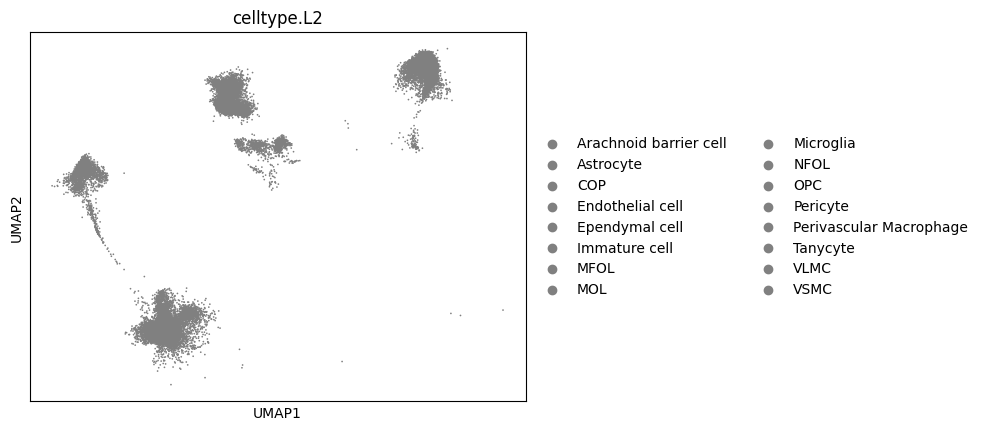

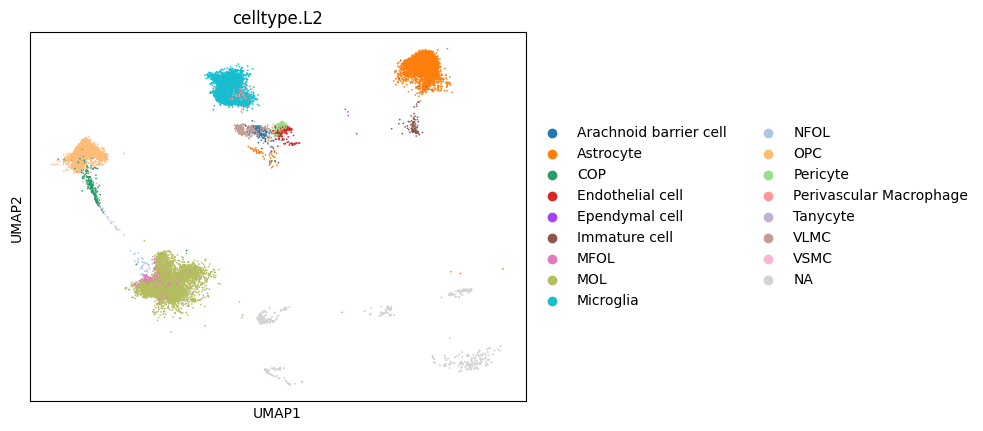

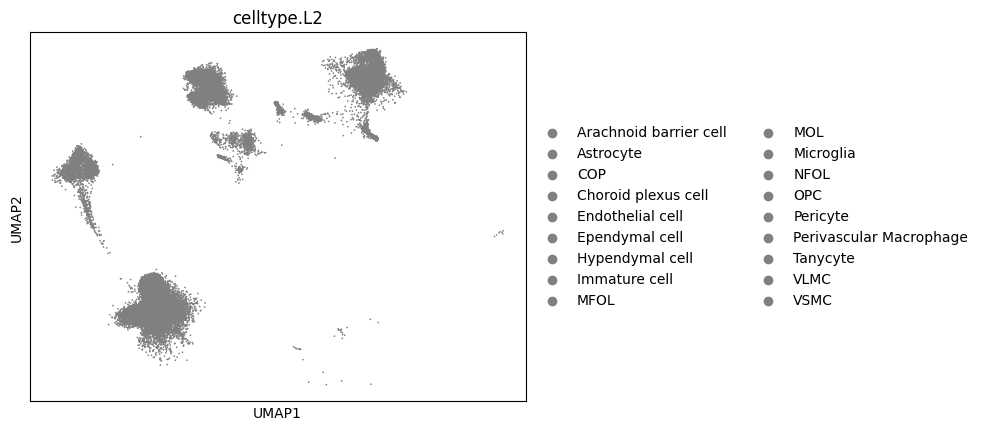

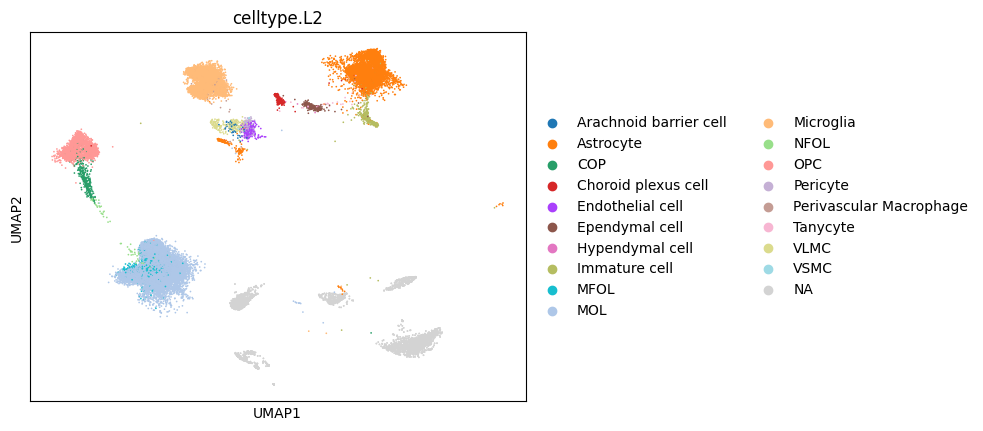

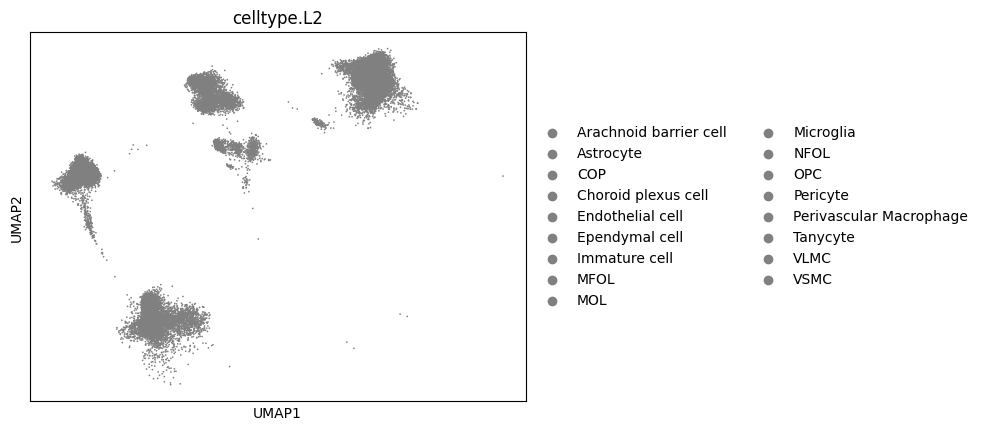

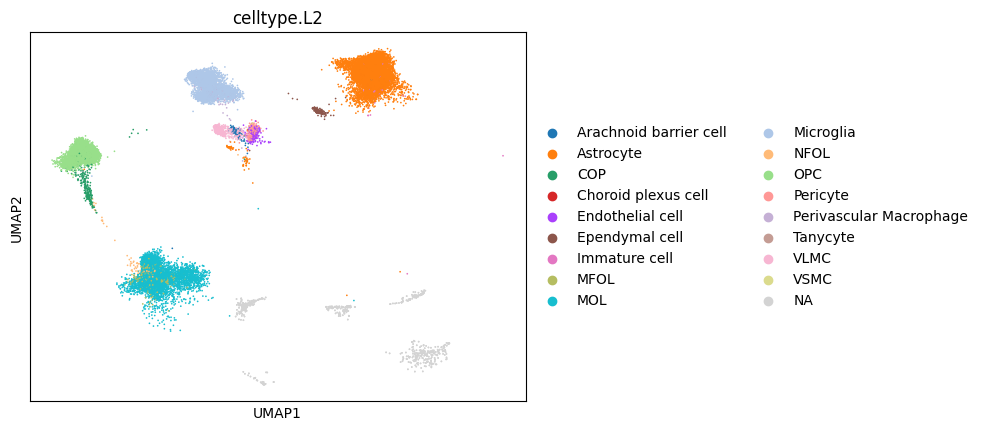

In [73]:
for region in adata_sc.obs['region'].unique():
#for region in ['HPF']:
    adata_cg_region_neuron = adata_meth_mcg[adata_meth_mcg.obs.region.isin([region]) & (adata_meth_mcg.obs.NeuroTransmitters=='NN')]
    adata_ch_region_neuron = adata_meth_mch[adata_meth_mch.obs.region.isin([region]) & (adata_meth_mch.obs.NeuroTransmitters=='NN')]

    #adata_atac_region_neuron = sc.read_h5ad(f'/data2st1/junyi/output/atac0627/3REGIONS_gene_{region}_NN.h5ad')
    adata_sc_region_neuron = adata_sc[adata_sc.obs.region.isin([region]) & (~adata_sc.obs.Neurotransmitter_celltype.isin(['GABAergic', 'Glutamatergic']))]
    sc.pl.umap(adata_sc_region_neuron, color=['celltype.L2'],size=6, show=True)
    #sc.pp.normalize_per_cell(adata_atac_region_neuron)
    #adata_atac_region_neuron.X.max()
    n_top_genes = 20000
    sc.pp.highly_variable_genes(adata_cg_region_neuron, n_top_genes=n_top_genes, batch_key="Sample")
    sc.pp.highly_variable_genes(adata_ch_region_neuron, n_top_genes=n_top_genes, batch_key="Sample")

    sc.pp.highly_variable_genes(adata_sc_region_neuron, n_top_genes=n_top_genes, batch_key="sample")
    sc_hvf = adata_sc_region_neuron.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_top_genes].index
    cg_hvf = adata_cg_region_neuron.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_top_genes].index
    ch_hvf = adata_ch_region_neuron.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_top_genes].index

    #hvfs = cg_hvf.intersection(ch_hvf).intersection(sc_hvf)
    # query = adata_atac_region_neuron[:,hvfs].copy()
    # reference = adata_sc_region_neuron[:,hvfs].copy()

    sc.pp.scale(adata_ch_region_neuron)
    sc.pp.scale(adata_cg_region_neuron)
    sc.pp.scale(adata_sc_region_neuron)

    adata_ch_region_neuron.X = adata_ch_region_neuron.X * -1
    adata_cg_region_neuron.X = adata_cg_region_neuron.X * -1
    adata_sc_region_neuron.var['gene_name'] = adata_sc_region_neuron.var_names
    adata_sc_region_neuron.var.index = adata_sc_region_neuron.var.gene_ids

    query1 = adata_cg_region_neuron
    query2 = adata_ch_region_neuron
    reference = adata_sc_region_neuron

    query1.obs['celltype.L2'] = pd.NA
    query2.obs['celltype.L2'] = pd.NA

    data = ad.concat(
        [reference, query1, query2],
        join='inner',
        label='batch',
        keys=["reference", "query1", "query2"],
        index_unique='_',
    )
    data

    sc.pl.umap(data, color=['celltype.L2'], size=6, show=True)
    sc.pp.filter_genes(data, min_cells=5)
    sc.pp.filter_cells(data, min_genes=200)
    # sc.pp.highly_variable_genes(
    #     data,
    #     n_top_genes = 5000,
    #     batch_key="batch"
    # )

    sc.pp.pca(data, n_comps=100,)
    data.write_h5ad(f'/data1st2/junyi/output/methlypub0823/{region}_atacsc_NN.h5ad')